In [1]:
!pip install tqdm torch torchvision --quiet

In [2]:
import os
import torch
import copy
from tqdm.notebook import tqdm
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt


# DATA PREPROCESSING

## Import data

In [3]:
def get_vids(path2imgs):
    listOfCats = os.listdir(path2imgs)
    print(listOfCats)
    ids = []
    labels = []
    for category in listOfCats:
        path2category = os.path.join(path2imgs, category)
        listOfvids = os.listdir(path2category)
        path2vids= [os.path.join(path2category,los) for los in listOfvids]
        ids.extend(path2vids)                       #extend adds each element of the list to the list being extend and not the whole list as 1 elem
        print([category.split('_')[0]]*len(listOfvids))
        labels.extend([category.split('_')[0]]*len(listOfvids))   #making the Y variable (labels are same for a list of videos)
    return ids, labels, listOfCats

In [4]:
path2data = "./Dataset"
sub_folder_jpg = "Cropped_Frames"
path2imgs = os.path.join(path2data, sub_folder_jpg)

all_vids, all_labels, cats = get_vids(path2imgs)
cats = [name.split('_')[0] for name in cats]

print(len(all_vids))
print(len(all_labels))


['pain_Cropped', 'call_Cropped', 'accident_Cropped', 'thief_Cropped', 'doctor_Cropped', 'hot_Cropped', 'help_Cropped', 'lose_Cropped']
['pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain', 'pain']
['call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call', 'call']
['accident', 'accident', 'accid

In [5]:
all_vids[:3]  #paths to the extracted frames

['./Dataset/Cropped_Frames/pain_Cropped/pain_Crop_018_01',
 './Dataset/Cropped_Frames/pain_Cropped/pain_Crop_019_02',
 './Dataset/Cropped_Frames/pain_Cropped/pain_Crop_011_02']

In [6]:
print(cats)
#assign int to each cat
labels_dict = {} #creating a dictonary for labels
ids = 0
for cat in cats:
    labels_dict[cat] = ids
    ids += 1

['pain', 'call', 'accident', 'thief', 'doctor', 'hot', 'help', 'lose']


## SPLIT DATA

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the ratio for train, validation, and test sets
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Initialize StratifiedShuffleSplit for train and test split
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)

# Get indices for train and test sets
train_indx, test_indx = next(sss_train_test.split(all_vids, all_labels))

print(type(train_indx))
# Convert indices to lists for slicing
train_indx = list(train_indx)
test_indx = list(test_indx)

# Get data for train, validation, and test sets
train_ids = [all_vids[ind] for ind in train_indx]
train_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in train_indx]

# Use train indices for train and validation split
sss_train_validation = StratifiedShuffleSplit(n_splits=1, test_size=validation_ratio, random_state=42)
train_indx, validation_indx = next(sss_train_validation.split(train_ids, train_labels))

# Get data for train, validation, and test sets
train_ids = [all_vids[ind] for ind in train_indx]
train_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in train_indx]
print("Train Set -", len(train_ids), "samples")

val_ids = [all_vids[ind] for ind in validation_indx]
val_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in validation_indx]
print("Validation Set -", len(val_ids), "samples")

test_ids = [all_vids[ind] for ind in test_indx]
test_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in test_indx]
print("Test Set -", len(test_ids), "samples")


<class 'numpy.ndarray'>
Train Set - 333 samples
Validation Set - 37 samples
Test Set - 42 samples


## Defining dataset

In [8]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)
timesteps =16
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")

        path2imgs = path2imgs[:timesteps]

        # print(self.labels[idx])
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:

            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        # print(frames_tr)
        # print(label)
        return frames_tr, label

In [9]:
# choose one model type by uncommenting

# model_type = "3dcnn"  #for r3d18 model
model_type = "rnn"      #for resent50 + lstm model


if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [10]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [11]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [12]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

333


In [13]:
imgs, label = train_ds[10]   #Each element of train_ds  is a set of images of that video and corresponding is the label
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 4, tensor(-2.1179), tensor(2.1462))

In [14]:
# Map numeric labels back to words using label_dict
labels_list = list(labels_dict.keys())
text_label = labels_list[label]
label, text_label

(4, 'doctor')

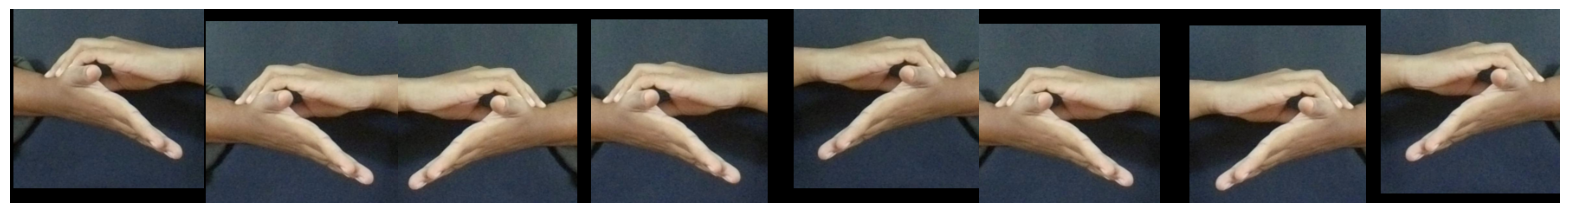

In [15]:
# train frames plot
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

In [16]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
val_ds = VideoDataset(ids= val_ids, labels= val_labels, transform= test_transformer)
print(len(test_ds))
print(len(val_ds))

42
37


## Defining Dataloader

In [17]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


batch_size = 32
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_rnn)
    val_dl = DataLoader(val_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_r3d_18)
    val_dl = DataLoader(val_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [18]:
for xb,yb in val_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([8, 16, 3, 224, 224]) torch.Size([8])


# MODEL DESCRIPTION

In [67]:
from torchvision import models
from torch import nn
from torch import nn

#defining our rnn model
class Resnt50Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt50Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.resnet50(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers) #512, 100, 1
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))

        intermediate_outputs = []
        intermediate_frames = [3, 7, 11]  #every 4th frame

        for ii in range(1, ts):
            y = self.baseModel((x[:, ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))

            # Save intermediate outputs for selected frames
            if ii in intermediate_frames:
                intermediate_outputs.append(self.fc1(self.dropout(out[:, -1])))

        out = self.dropout(out[:, -1])
        out = self.fc1(out)

        return out, intermediate_outputs

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x


In [68]:
from torch import nn
import os
from torchvision import models

# Create the directory if it does not exist
directory = "./models/"
os.makedirs(directory, exist_ok=True)
if model_type == "rnn":
    params_model={
        "num_classes": len(cats),
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 3,
        "rnn_hidden_size": 100,}
    model = Resnt50Rnn(params_model)   #resnet 50 model
else:
    model = models.video.r3d_18(pretrained=True, progress=False)   #r3d18 model
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(cats))

/users/ug21/pampamondaliitb/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/ug21/pampamondaliitb/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w)
    y,_ = model(x)
    print(y.shape)

torch.Size([1, 8])


In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [71]:
model

Resnt50Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [72]:
#saving model state
path2weights = os.path.join(directory, "weights.pt")
torch.save(model.state_dict(), path2weights)

##TRAIN MODEL

In [73]:
#Get the learning rate corresponding to optimizers
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


In [74]:
#loss of a particular batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():  #for evaluation only
        pred = output.argmax(dim=1, keepdim=True)
        corrects=pred.eq(target.view_as(pred)).sum().item()  #calculating accuracy
        metric_b = corrects
    if opt is not None:  #for training
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [75]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output, int_ops =model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b

        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric


In [76]:
#Function to train the model

def train_val(model, params , num_epochs):
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]   #should be false
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    early_stopping_patience = params["early_stopping_patience"]

    loss_history={
        "train": [],
        "val": [],
    }

    metric_history={
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    counter = 0

    for epoch in range(num_epochs):
        # print(opt.param_groups)
        for param_group in opt.param_groups:

            current_lr=param_group['lr']

        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
            #Store the best model
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        else:
            counter += 1

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)


        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)

        if counter >= early_stopping_patience:
            print(f"Early stopping after {epoch} epochs.")
            break
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [77]:
import gc
gc.collect()

1340

In [78]:
#training the model
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
#os.makedirs("./models", exist_ok=True)

params_train={
    #"num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "early_stopping_patience": 10,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train , num_epochs = 100)

Epoch 0/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.075117, dev loss: 2.060462, accuracy: 18.92
----------
Epoch 1/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.068554, dev loss: 2.056106, accuracy: 18.92
----------
Epoch 2/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.062947, dev loss: 2.053524, accuracy: 18.92
----------
Epoch 3/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.056551, dev loss: 2.050150, accuracy: 18.92
----------
Epoch 4/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.051813, dev loss: 2.048639, accuracy: 18.92
----------
Epoch 5/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.044604, dev loss: 2.045848, accuracy: 18.92
----------
Epoch 6/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.039785, dev loss: 2.040055, accuracy: 18.92
----------
Epoch 7/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.034221, dev loss: 2.036949, accuracy: 18.92
----------
Epoch 8/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.026326, dev loss: 2.031955, accuracy: 27.03
----------
Epoch 9/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.018063, dev loss: 2.028475, accuracy: 27.03
----------
Epoch 10/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.010220, dev loss: 2.021862, accuracy: 29.73
----------
Epoch 11/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.004283, dev loss: 2.018143, accuracy: 29.73
----------
Epoch 12/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.997188, dev loss: 2.014649, accuracy: 29.73
----------
Epoch 13/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.991936, dev loss: 2.011975, accuracy: 32.43
----------
Epoch 14/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.981418, dev loss: 2.004906, accuracy: 35.14
----------
Epoch 15/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.973651, dev loss: 2.004255, accuracy: 29.73
----------
Epoch 16/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.967230, dev loss: 1.996649, accuracy: 37.84
----------
Epoch 17/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.958749, dev loss: 1.989977, accuracy: 35.14
----------
Epoch 18/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.945968, dev loss: 1.981061, accuracy: 37.84
----------
Epoch 19/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.942769, dev loss: 1.975027, accuracy: 35.14
----------
Epoch 20/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.928711, dev loss: 1.968074, accuracy: 37.84
----------
Epoch 21/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.921044, dev loss: 1.963863, accuracy: 40.54
----------
Epoch 22/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.904413, dev loss: 1.954344, accuracy: 37.84
----------
Epoch 23/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.895707, dev loss: 1.945061, accuracy: 45.95
----------
Epoch 24/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.887747, dev loss: 1.938442, accuracy: 43.24
----------
Epoch 25/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.873000, dev loss: 1.931417, accuracy: 43.24
----------
Epoch 26/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.858656, dev loss: 1.920399, accuracy: 43.24
----------
Epoch 27/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.839773, dev loss: 1.906828, accuracy: 54.05
----------
Epoch 28/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.826770, dev loss: 1.891983, accuracy: 56.76
----------
Epoch 29/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.815788, dev loss: 1.881736, accuracy: 51.35
----------
Epoch 30/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.798487, dev loss: 1.865496, accuracy: 51.35
----------
Epoch 31/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.778918, dev loss: 1.856078, accuracy: 54.05
----------
Epoch 32/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.762947, dev loss: 1.839737, accuracy: 59.46
----------
Epoch 33/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.745701, dev loss: 1.827243, accuracy: 62.16
----------
Epoch 34/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.716212, dev loss: 1.804352, accuracy: 67.57
----------
Epoch 35/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.705814, dev loss: 1.808961, accuracy: 62.16
----------
Epoch 36/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.678929, dev loss: 1.771873, accuracy: 78.38
----------
Epoch 37/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.660772, dev loss: 1.763378, accuracy: 67.57
----------
Epoch 38/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.647210, dev loss: 1.738448, accuracy: 70.27
----------
Epoch 39/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.625081, dev loss: 1.713784, accuracy: 75.68
----------
Epoch 40/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.600450, dev loss: 1.700012, accuracy: 70.27
----------
Epoch 41/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.585189, dev loss: 1.673558, accuracy: 81.08
----------
Epoch 42/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.554110, dev loss: 1.657657, accuracy: 83.78
----------
Epoch 43/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.532010, dev loss: 1.633008, accuracy: 83.78
----------
Epoch 44/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.508384, dev loss: 1.621983, accuracy: 81.08
----------
Epoch 45/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.477463, dev loss: 1.607138, accuracy: 75.68
----------
Epoch 46/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.466513, dev loss: 1.570894, accuracy: 86.49
----------
Epoch 47/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.427772, dev loss: 1.556275, accuracy: 83.78
----------
Epoch 48/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.418459, dev loss: 1.566559, accuracy: 81.08
----------
Epoch 49/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.408790, dev loss: 1.541460, accuracy: 83.78
----------
Epoch 50/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.365776, dev loss: 1.478292, accuracy: 86.49
----------
Epoch 51/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.354323, dev loss: 1.473599, accuracy: 83.78
----------
Epoch 52/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.328660, dev loss: 1.449691, accuracy: 86.49
----------
Epoch 53/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.311749, dev loss: 1.416683, accuracy: 83.78
----------
Epoch 54/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.291568, dev loss: 1.395168, accuracy: 86.49
----------
Epoch 55/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.261817, dev loss: 1.396114, accuracy: 86.49
----------
Epoch 56/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.240445, dev loss: 1.368238, accuracy: 83.78
----------
Epoch 57/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.222546, dev loss: 1.349032, accuracy: 86.49
----------
Epoch 58/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.203979, dev loss: 1.348318, accuracy: 81.08
----------
Epoch 59/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.184447, dev loss: 1.345040, accuracy: 86.49
----------
Epoch 60/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.166831, dev loss: 1.316947, accuracy: 86.49
----------
Epoch 61/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.152114, dev loss: 1.310571, accuracy: 81.08
----------
Epoch 62/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.128529, dev loss: 1.275189, accuracy: 83.78
----------
Epoch 63/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.119133, dev loss: 1.274471, accuracy: 86.49
----------
Epoch 64/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.089832, dev loss: 1.247000, accuracy: 89.19
----------
Epoch 65/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.077283, dev loss: 1.215454, accuracy: 81.08
----------
Epoch 66/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.050132, dev loss: 1.188637, accuracy: 89.19
----------
Epoch 67/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.039482, dev loss: 1.197461, accuracy: 86.49
----------
Epoch 68/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.017043, dev loss: 1.206598, accuracy: 83.78
----------
Epoch 69/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.010872, dev loss: 1.167766, accuracy: 89.19
----------
Epoch 70/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.995186, dev loss: 1.151580, accuracy: 89.19
----------
Epoch 71/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.969636, dev loss: 1.184807, accuracy: 91.89
----------
Epoch 72/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.956120, dev loss: 1.113365, accuracy: 91.89
----------
Epoch 73/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.928325, dev loss: 1.100324, accuracy: 89.19
----------
Epoch 74/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.924022, dev loss: 1.082780, accuracy: 91.89
----------
Epoch 75/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.900557, dev loss: 1.082499, accuracy: 91.89
----------
Epoch 76/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.890381, dev loss: 1.053405, accuracy: 89.19
----------
Epoch 77/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.872171, dev loss: 1.041960, accuracy: 94.59
----------
Epoch 78/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.865146, dev loss: 1.014543, accuracy: 94.59
----------
Epoch 79/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.851717, dev loss: 1.028586, accuracy: 91.89
----------
Epoch 80/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.838272, dev loss: 0.979299, accuracy: 94.59
----------
Epoch 81/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.829470, dev loss: 0.970291, accuracy: 91.89
----------
Epoch 82/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.806965, dev loss: 0.979422, accuracy: 94.59
----------
Epoch 83/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.793824, dev loss: 0.940444, accuracy: 91.89
----------
Epoch 84/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.781758, dev loss: 0.943571, accuracy: 89.19
----------
Epoch 85/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.770359, dev loss: 0.963897, accuracy: 89.19
----------
Epoch 86/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.765097, dev loss: 0.957758, accuracy: 86.49
----------
Epoch 87/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.741226, dev loss: 0.898824, accuracy: 91.89
----------
Epoch 88/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.729905, dev loss: 1.016940, accuracy: 81.08
----------
Epoch 89/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.722699, dev loss: 0.862299, accuracy: 94.59
----------
Epoch 90/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.704695, dev loss: 0.926596, accuracy: 89.19
----------
Epoch 91/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.704697, dev loss: 0.862049, accuracy: 91.89
----------
Epoch 92/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.691831, dev loss: 0.868213, accuracy: 89.19
----------
Epoch 93/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.678026, dev loss: 0.822898, accuracy: 94.59
----------
Epoch 94/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.663498, dev loss: 0.845472, accuracy: 89.19
----------
Epoch 95/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.667270, dev loss: 0.912002, accuracy: 89.19
----------
Epoch 96/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.648705, dev loss: 0.793113, accuracy: 94.59
----------
Epoch 97/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.633006, dev loss: 0.786103, accuracy: 94.59
----------
Epoch 98/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.629334, dev loss: 0.801670, accuracy: 89.19
----------
Epoch 99/99, current lr=3e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.613285, dev loss: 0.751244, accuracy: 94.59
----------


# EVALUATE MODEL

In [79]:
# import tarfile

# # Specify the path to the tar file
# tar_file_path = '/content/drive/MyDrive/AI_ML_project/models.tar'

# # Specify the directory where you want to extract the contents
# extract_path = '/content/drive/MyDrive/AI_ML_project/'

# # Open the tar file
# with tarfile.open(tar_file_path, 'r') as tar:
#     # Extract all contents to the specified directory
#     tar.extractall(extract_path)

# print(f"Successfully extracted contents to {extract_path}")


In [80]:
path2model = "./models/weights_"+model_type+".pt"
saved_state_dict = torch.load(path2model)
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

## Test accuracy

In [81]:
# Evaluate on test data

def test_model(model, test_dl, loss_func, device):
    model.eval()
    running_metric = 0.0
    len_data = len(test_dl.dataset)

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            output, int_ops = model(xb)

            loss_b, metric_b = loss_batch(loss_func, output, yb)
            running_metric += metric_b
    print(int_ops)
    metric = running_metric / float(len_data)

    print(f"Test accuracy: {100 * metric:.2f}%")

    return metric


In [82]:
test_acc = test_model(model, test_dl, loss_func, device)

[tensor([[-0.7258, -0.0747,  2.4448, -0.1254, -0.3224, -0.5733,  0.1462, -0.9709],
        [-0.6160, -0.5818, -0.0767,  0.5355,  0.1838, -0.3388,  2.1618, -1.1577]]), tensor([[-0.6788, -0.0603,  2.7129, -0.1237, -0.3190, -0.5984,  0.0914, -1.1383],
        [-0.5797, -0.6053, -0.0852,  0.5811,  0.2405, -0.3379,  2.2476, -1.2700]]), tensor([[-0.6815, -0.0642,  2.7384, -0.1193, -0.3245, -0.6013,  0.0984, -1.1485],
        [-0.5812, -0.6107, -0.0807,  0.5931,  0.2337, -0.3396,  2.2638, -1.2758]])]
Test accuracy: 88.10%


## Accuracy and loss curves

In [83]:
def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

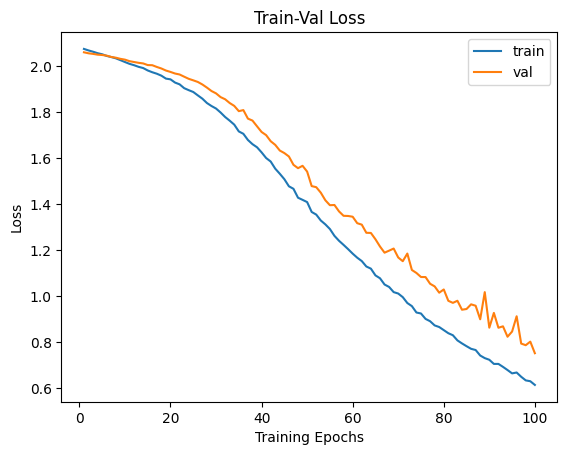

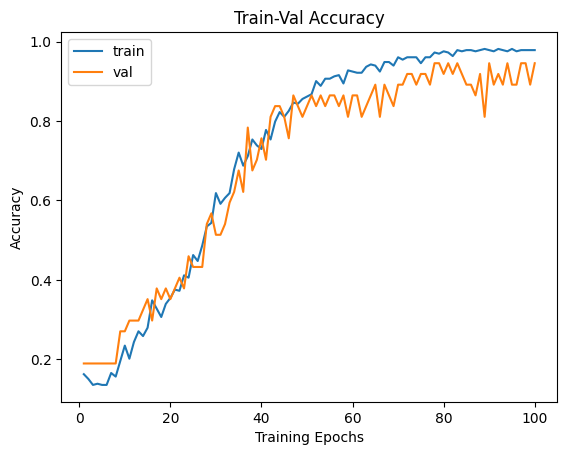

In [84]:
plot_loss(loss_hist, metric_hist)

## intermediate frame predictions

In [85]:
def see_intermediate_labels(model, test_dl, device):
    model.eval()
    all_combined_labels = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            output, int_ops = model(xb)

            predictions = torch.argmax(output, dim=1).cpu().numpy()
            int_ops_labels = [torch.argmax(frame, dim=1).cpu().numpy() for frame in int_ops]
            
            print(predictions)
            print(int_ops_labels)
            labels = yb.cpu().numpy()
            all_labels.extend(labels)

            combined_labels = [[frame_labels[i] for frame_labels in int_ops_labels] + [predictions[i]] for i in range(len(predictions))]
            all_combined_labels.extend(combined_labels)

    return all_combined_labels, all_labels


In [86]:
all_inter_labels, true_labels = see_intermediate_labels(model, test_dl, device)

[5 1 4 2 1 0 4 0]
[array([5, 5, 4, 2, 2, 5, 4, 0]), array([5, 1, 4, 2, 1, 0, 4, 1]), array([5, 1, 4, 2, 0, 0, 4, 1])]
[3 5 2 1 3 6 0 3]
[array([3, 5, 2, 1, 3, 6, 0, 3]), array([0, 5, 2, 1, 3, 6, 0, 3]), array([0, 5, 2, 1, 3, 6, 0, 3])]
[1 0 5 0 4 6 5 6]
[array([5, 0, 5, 0, 4, 6, 5, 6]), array([1, 0, 5, 5, 4, 6, 5, 6]), array([1, 0, 5, 0, 4, 6, 5, 6])]
[5 4 4 0 6 1 2 3]
[array([5, 4, 4, 3, 6, 1, 2, 3]), array([1, 4, 4, 0, 6, 1, 2, 3]), array([5, 4, 4, 0, 6, 1, 2, 3])]
[5 6 0 3 3 1 2 2]
[array([5, 6, 0, 3, 3, 1, 2, 2]), array([5, 6, 0, 3, 3, 1, 2, 3]), array([5, 6, 0, 3, 3, 1, 2, 3])]
[2 6]
[array([2, 6]), array([2, 6]), array([2, 6])]


In [87]:
all_inter_labels[:3] #list of lists with each list containing the predictions at timesteps 4,8,12 and the final prediction

[[5, 5, 5, 5], [5, 1, 1, 1], [4, 4, 4, 4]]

In [88]:
len(true_labels)

42

In [89]:
test_inter_labels = [labels_list[l] for l in all_inter_labels[0]]
test_inter_labels

['hot', 'hot', 'hot', 'hot']

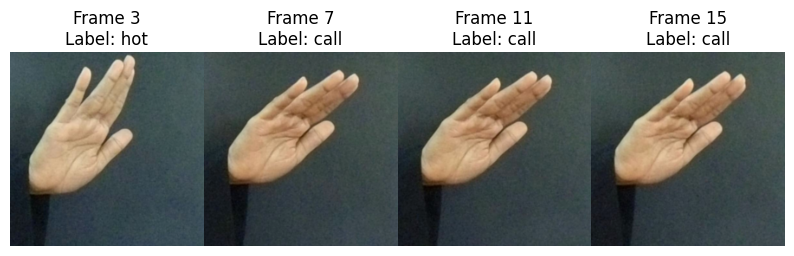

In [90]:
# VISUALIZE

batch_iterator = iter(test_dl)
vid_index = 1

# Fetch the batch using the iterator
# Fetch the 1st batch
batch_1 = next(batch_iterator)

# Fetch the 2nd batch
batch_2 = next(batch_iterator)

# Extract specific frames from the batch
frames_to_plot = [3, 7, 11, 15]  # 0-based indices for the frames to plot

imgs_test_1, label = batch_1
imgs_test_2, label = batch_2

# Plot the selected frames
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)

img_test = imgs_test_1[vid_index]
label_sequence = [labels_list[l] for l in all_inter_labels[vid_index]]

for i, idx in enumerate(frames_to_plot):
    img = img_test[idx]

    # print(img.shape)
    plt.subplot(1, len(frames_to_plot), i + 1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(f"Frame {idx}\nLabel: {label_sequence[i]}")
    plt.axis("off")

plt.show()


In [91]:
labels_list[label[0]] # true label

'lose'

## P, R, F1, Confusion matrix

In [92]:
!pip install seaborn

In [93]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_dl, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            output,int_ops = model(xb)

            predictions = torch.argmax(output, dim=1).cpu().numpy()
            labels = yb.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels)

    # Calculate precision and recall
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Create confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    norm_confusion_mat = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    # cm = pd.DataFrame(conf_matrix, columns = labels , index = labels)
    # cm_norm = pd.DataFrame(norm_confusion_mat, columns = labels , index = labels)

    return precision, recall, f1, conf_matrix, norm_confusion_mat

In [94]:
def plot_cm_heatmap(confusion_mat, normalized_confusion_mat, labels):
    # Create a heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(normalized_confusion_mat*100, fmt=".2f", annot=True, cmap="Greens", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Create a heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="viridis", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

### Intermediate frames CM

4th frame Confusion matrices:


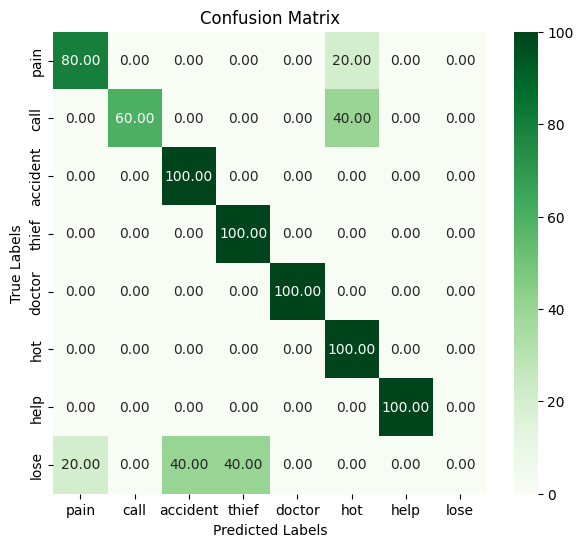

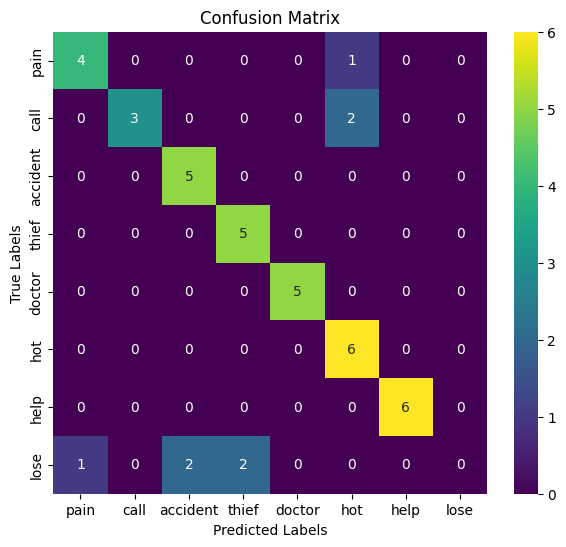

8th frame Confusion matrices:


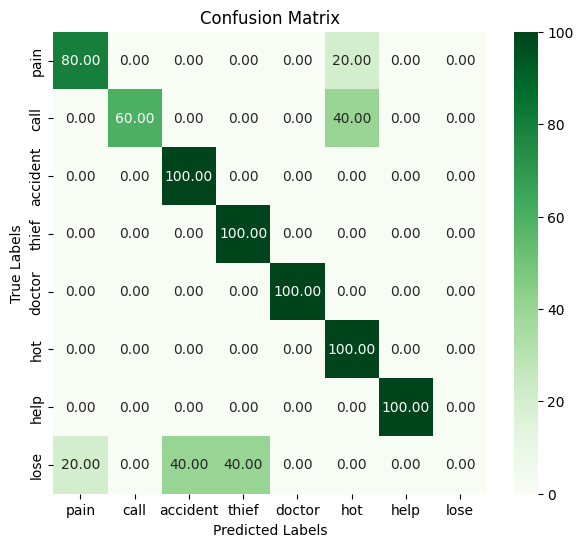

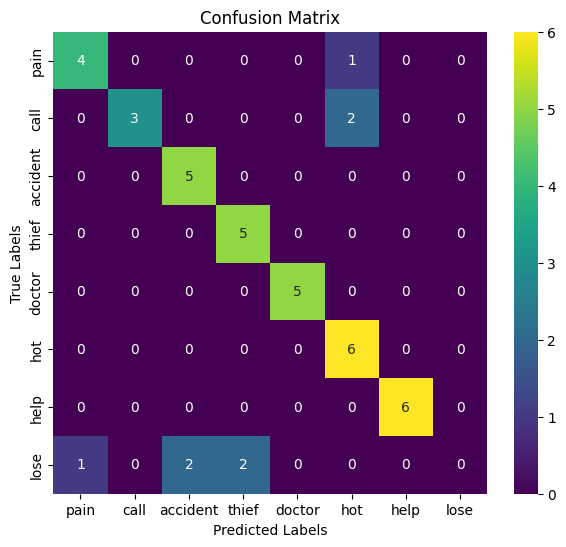

11th frame Confusion matrices:


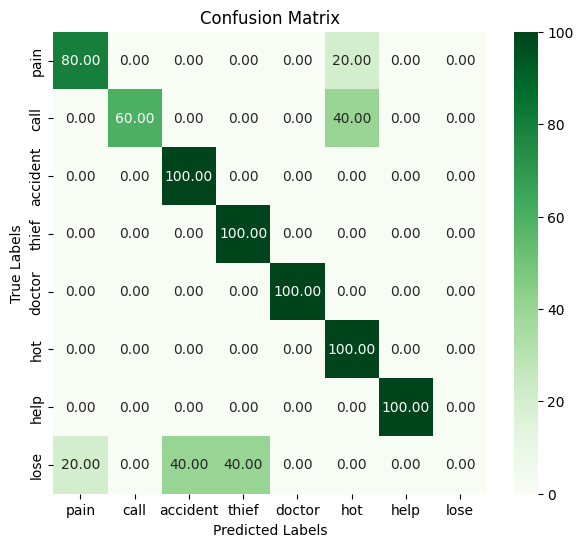

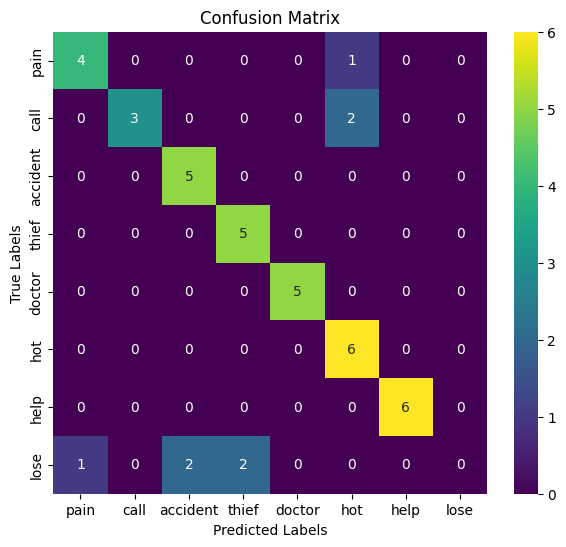

In [95]:
import numpy as np

all_inter_labels_arr = np.array(all_inter_labels)
frame1_pred = all_inter_labels_arr[:,0]
frame2_pred = all_inter_labels_arr[:,1]
frame3_pred = all_inter_labels_arr[:,2]


cm1 = confusion_matrix(true_labels, frame1_pred)
norm_cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]

cm2 = confusion_matrix(true_labels, frame2_pred)
norm_cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

cm3 = confusion_matrix(true_labels, frame3_pred)
norm_cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

print("4th frame Confusion matrices:")
plot_cm_heatmap(cm1, norm_cm1, cats)
print("8th frame Confusion matrices:")
plot_cm_heatmap(cm2, norm_cm2, cats)
print("11th frame Confusion matrices:")
plot_cm_heatmap(cm3, norm_cm3, cats)
# frame1_pred, frame2_pred, frame3_pred, all_labels


In [96]:
### Final results

In [97]:
precision, recall, f1, cm, norm_cm = evaluate_model(model, test_dl, device)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7874
Recall: 0.8810
F1 Score: 0.8286


/users/ug21/pampamondaliitb/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


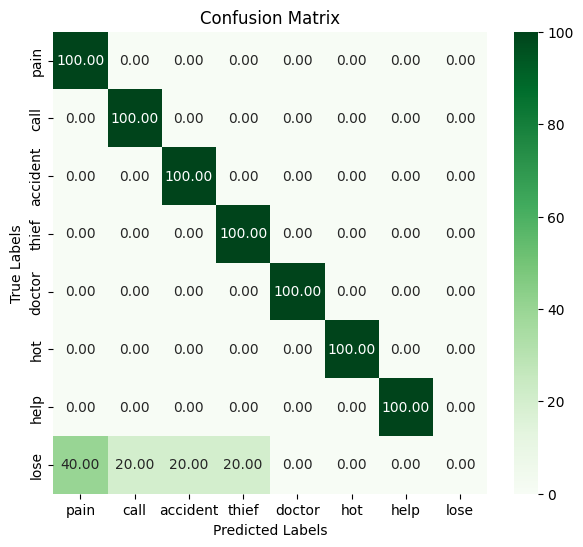

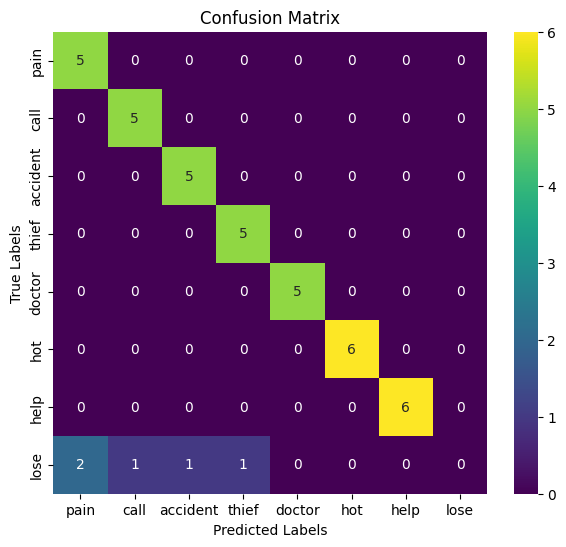

In [98]:
plot_cm_heatmap(cm, norm_cm, cats)